# Modelos, validación cruzada y dimensionamiento de la apuesta

## Objetivos

- Revisar algunos algortimos de Advances in Financial Machine Learning. Capítulo 6, 7 y 10.
- Métodos de ensamble, validación cruzada y dimensionamiento de la apuesta.


## Bibliografia

- Marcos Lopez de Prado. Advances in Financial Machine Learning. Wiley

## Recursos

- Python 3.7+
- Jupyter notebook.
- Pandas
- numpy
- matplotlib
- stattools

## Descripcion

A partir de notebooks anteriores, mostramos en este caso como utilizar algunos algoritmos de ensamble
con configuraciones de hiperparametros basicas. Luego, incorporamos validacion cruzada y la comparamos
con el empleo de purga y embargo. Finalmente, tomamos las predicciones y realizamos un dimensionamiento
de la apuesta con la probabilidad.

In [1]:
from itertools import cycle

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from scipy import interp
from scipy.stats import norm

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection._split import _BaseKFold
from sklearn.metrics import roc_curve, classification_report, log_loss, accuracy_score, auc

In [2]:
# %load mpfin.py
import multiprocessing as mp
import datetime as dt
import time
import sys

def mpPandasObj(func,pdObj,numThreads=24,mpBatches=1,linMols=True,**kargs):
    '''
    Parallelize jobs, return a dataframe or series
    multiprocessing snippet [20.7]
    + func: function to be parallelized. Returns a DataFrame
    + pdObj[0]: Name of argument used to pass the molecule
    + pdObj[1]: List of atoms that will be grouped into molecules
    + kwds: any other argument needed by func

    Example: df1=mpPandasObj(func,('molecule',df0.index),24,**kwds)
    '''
    import pandas as pd
    #if linMols:parts=linParts(len(argList[1]),numThreads*mpBatches)
    #else:parts=nestedParts(len(argList[1]),numThreads*mpBatches)
    if linMols:parts=linParts(len(pdObj[1]),numThreads*mpBatches)
    else:parts=nestedParts(len(pdObj[1]),numThreads*mpBatches)

    jobs=[]
    for i in range(1,len(parts)):
        job={pdObj[0]:pdObj[1][parts[i-1]:parts[i]],'func':func}
        job.update(kargs)
        jobs.append(job)
    if numThreads==1:out=processJobs_(jobs)
    else: out=processJobs(jobs,numThreads=numThreads)
    if isinstance(out[0],pd.DataFrame):df0=pd.DataFrame()
    elif isinstance(out[0],pd.Series):df0=pd.Series()
    else:return out
    for i in out:df0=df0.append(i)
    df0=df0.sort_index()
    return df0

def processJobs_(jobs):
    # Run jobs sequentially, for debugging
    out=[]
    for job in jobs:
        out_=expandCall(job)
        out.append(out_)
    return out


def linParts(numAtoms,numThreads):
    # partition of atoms with a single loop
    parts=np.linspace(0,numAtoms,min(numThreads,numAtoms)+1)
    parts=np.ceil(parts).astype(int)
    return parts

def nestedParts(numAtoms,numThreads,upperTriang=False):
    # partition of atoms with an inner loop
    parts,numThreads_=[0],min(numThreads,numAtoms)
    for num in range(numThreads_):
        part=1+4*(parts[-1]**2+parts[-1]+numAtoms*(numAtoms+1.)/numThreads_)
        part=(-1+part**.5)/2.
        parts.append(part)
    parts=np.round(parts).astype(int)
    if upperTriang: # the first rows are heaviest
        parts=np.cumsum(np.diff(parts)[::-1])
        parts=np.append(np.array([0]),parts)
    return parts

import datetime as dt

def reportProgress(jobNum,numJobs,time0,task):
    # Report progress as asynch jobs are completed
    msg=[float(jobNum)/numJobs, (time.time()-time0)/60.]
    msg.append(msg[1]*(1/msg[0]-1))
    timeStamp=str(dt.datetime.fromtimestamp(time.time()))
    msg=timeStamp+' '+str(round(msg[0]*100,2))+'% '+task+' done after '+ \
        str(round(msg[1],2))+' minutes. Remaining '+str(round(msg[2],2))+' minutes.'
    if jobNum<numJobs:sys.stderr.write(msg+'\r')
    else:sys.stderr.write(msg+'\n')
    return

def processJobs(jobs,task=None,numThreads=24):
    # Run in parallel.
    # jobs must contain a 'func' callback, for expandCall
    if task is None:task=jobs[0]['func'].__name__
    pool=mp.Pool(processes=numThreads)
    outputs,out,time0=pool.imap_unordered(expandCall,jobs),[],time.time()
    # Process asyn output, report progress
    for i,out_ in enumerate(outputs,1):
        out.append(out_)
        reportProgress(i,len(jobs),time0,task)
    pool.close();pool.join() # this is needed to prevent memory leaks
    return out

def expandCall(kargs):
    # Expand the arguments of a callback function, kargs['func']
    func=kargs['func']
    del kargs['func']
    out=func(**kargs)
    return out


In [3]:
# %load labelling.py
import numpy as np
import pandas as pd

def getDailyVol(close, span0=100):
    '''
    Computes the daily volatility of price returns.
    It takes a closing price series, applies a diff sample to sample
    (assumes each sample is the closing price), computes an EWM with 
    `span0` samples and then the standard deviation of it.
    
    See Advances in Financial Analytics, snippet 3.1
    
    @param[in] close A series of prices where each value is the closing price of an asset.
               The index of the series must be a valid datetime type.
    @param[in] span0 The sample size of the EWM.
    @return A pandas series of daily return volatility.
    '''
    df0 = close.index.searchsorted(close.index-pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(close.index[df0-1], index=close.index[close.shape[0]-df0.shape[0]:])
    df0 = close.loc[df0.index] / close.loc[df0.values].values-1 # Daily returns
    df0 = df0.ewm(span=span0).std()
    return df0

def getVerticalBarrier(tEvents, close, numDays=0):
    """
    Adding a Vertical Barrier
    For each index in t_events, it finds the timestamp of the next price bar at or immediately after
    a number of days num_days. This vertical barrier can be passed as an optional argument t1 in get_events.
    This function creates a series that has all the timestamps of when the vertical barrier would be reached.
    
    Advances in Financial Machine Learning, Snippet 3.4 page 49.
    
    @param tEvents A pd.DateTimeIndex of events.
    @param close A pd.Series of close prices.
    @param numDays The number of days to add for vertical barrier.
    @return A pd.Series of Timestamps of vertical barriers
    """
    verticalBarrier = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
    verticalBarrier = verticalBarrier[verticalBarrier < close.shape[0]]
    return pd.Series(close.index[verticalBarrier], index = tEvents[:verticalBarrier.shape[0]]) # NaNs at the end

def applyPtSlOnT1(close, events, ptSl, molecule):
    '''
    Apply stop loss/profit taking, if it takes place before t1 (vertical barrier)
    (end of event).
    
    Advances in Financial Machine Learning, snippet 3.2 page 45.
    @param close
    @param events
    @param ptSl
    @param molecule
    @return
    '''
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    
    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index) # NaNs
    
    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl=pd.Series(index=events.index) # NaNs
    
    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1] # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc,'side'] # path returns
        out.loc[loc,'sl'] = df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt'] = df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet
    #2) get t1 (max holding period)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)
    #3) form events object, apply stop loss on t1
    if side is None:
        side_, ptSl_ = pd.Series(1.,index=trgt.index), [ptSl[0],ptSl[0]]
    else:
        side_, ptSl_= side.loc[trgt.index],ptSl[:2]
    events = (pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1) .dropna(subset=['trgt']))
    df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index),
                    numThreads=numThreads,close=close,events=events,
                    ptSl=ptSl_)
    events['t1'] = df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:events=events.drop('side',axis=1)
    return events

def getBinsOld(events,close):
    # Snippet 3.5
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    out['bin']=np.sign(out['ret'])
    # Where out index and t1 (vertical barrier) intersect label 0
    # See page 49, it is a suggested exercise.
    try:
        locs = out.query('index in @t1').index
        out.loc[locs, 'bin'] = 0
    except:
        pass
    return out


def getBins(events, close):
    '''
    Compute event's outcome (including side information, if provided).
    
    Snippet 3.7
    
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    
    @param events It's a dataframe whose 
      - index is event's starttime
      - Column t1 is event's endtime
      - Column trgt is event's target
      - Column side (optional) implies the algo's position side.
    @param close It's a close price series.
    '''
    #1) prices aligned with events
    events_=events.dropna(subset=['t1'])
    px=events_.index.union(events_['t1'].values).drop_duplicates()
    px=close.reindex(px,method='bfill')
    #2) create out object
    out=pd.DataFrame(index=events_.index)
    out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
    if 'side' in events_:
        out['ret']*=events_['side'] # meta-labeling
    out['bin']=np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret']<=0,'bin']=0 # meta-labeling
    return out


def dropLabels(events, minPct=.05):
    '''
    Takes a dataframe of events and removes those labels that fall
    below minPct (minimum percentil).
    
    Snippet 3.8
    
    @param events An events dataframe, such as the output of getBins()
    @param minPct The minimum percentil of rare labels to have.
    @return The input @p events dataframe but filtered.
    '''
    # apply weights, drop labels with insufficient examples
    while True:
        df0=events['bin'].value_counts(normalize=True)
        if df0.min()>minPct or df0.shape[0]<3:break
        print('dropped label: ', df0.argmin(),df0.min())
        events=events[events['bin']!=df0.argmin()]
    return events

In [4]:
# %load events.py
def cusumFilterEvents(close, threshold):
    '''
    Symmetric CUSUM Filter.
    It is a quality-control method, designed to detect a shift in
    the mean value of the measured quantity away from a target value.
    The value of each filter is:
      S^{+}_t = max{0, S^{+}_{t-1} + y_t - E_{t-1}[y_t]}, S^{+}_0 = 0
      S^{-}_t = mix{0, S^{-}_{t-1} + y_t - E_{t-1}[y_t]}, S^{-}_0 = 0
      S_t = max{S^{+}_t, -S^{-}_t}

    See Advances in Financial Analytics, snippet 2.4, page 39.


    @param close A price series.
    @param threshold A positive threshold to flag a positive or negative
           event when either S^{+}_t or S^{-}_t is greater than it.
    @return A subset of the @p close index series where the events of
            filter are triggered.
    '''
    tEvents = []
    sPos = 0
    sNeg = 0
    
    diff = close.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos+diff.loc[i]), min(0, sNeg+diff.loc[i])
        if sNeg < -threshold:
            sNeg = 0
            tEvents.append(i)
        elif sPos > threshold:
            sPos = 0
            tEvents.append(i)
    return pd.to_datetime(tEvents)


def getEwmDf(close, fast_window_num_days=3, slow_window_num_days=7):
    '''
    Generates a close prices dataframe with three columns, where:
    - Column "close" is the `close` price.
    - Column "fast" is the `fast` EWM with @p fast_window_num_days days window size.
    - Column "slow" is the `slow` EWM with @p slow_window_num_days days window size.
    
    @param close A pandas series of close daily prices.
    @param fast_window_num_days A positive integer indicating the fast window size in days.
    @param slow_window_num_days A positive integer indicating the slow window size in days,
           which is greater than @p fast_window_num_days.
    @return A dataframe as described above.
    '''
    close_df = (pd.DataFrame()
                .assign(close=close)
                .assign(fast=close.ewm(fast_window_num_days).mean())
                .assign(slow=close.ewm(slow_window_num_days).mean()))
    return close_df

def get_up_cross(df):
    '''
    @return A pandas series of events from @p df (as provided in getEwmDf()) when the 
            fast signal crosses over the slow signal positively. 
    '''
    crit1 = df.fast.shift(1) < df.slow.shift(1)
    crit2 = df.fast > df.slow
    return df.fast[(crit1) & (crit2)]

def get_down_cross(df):
    '''
    @return A pandas series of events from @p df (as provided in getEwmDf()) when the 
            fast signal crosses over the slow signal positively. 
    '''
    crit1 = df.fast.shift(1) > df.slow.shift(1)
    crit2 = df.fast < df.slow
    return df.fast[(crit1) & (crit2)]

def getEwmEvents(close, fast_window_num_days=3, slow_window_num_days=7):
    '''
    Generates a pandas series from @p close price series whose events are generated
    from the EWM fast and slow signal crosses. When the fast signal crosses with a
    positive slope the slow signal a "1" is flagged and when the opposite happens
    a "-1" is flagged.
    
    @param close A pandas series of close daily prices.
    @param fast_window_num_days A positive integer indicating the fast window size in days.
    @param slow_window_num_days A positive integer indicating the slow window size in days,
           which is greater than @p fast_window_num_days.
    @return A pandas series of events of buy and sell signals.
    '''
    close_df = getEwmDf(close, fast_window_num_days, slow_window_num_days)
    up_events = get_up_cross(close_df)
    down_events = get_down_cross(close_df)
    side_up = pd.Series(1, index=up_events.index)
    side_down = pd.Series(-1, index=down_events.index)
    return pd.concat([side_up,side_down]).sort_index()
    

In [5]:
# %load frac_diff.py
def getWeights(d,size):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 
    
    @param d A non-negative real that represents the degree of the differentiation.
    @param size The number of items .
    @return A list with the fractionally differentiated coefficients.
    '''
    w=[1.]
    for k in range(1,size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1,1)
    return w


def getWeights_FFD(d,thres):
    '''
    Returns a list of coefficients to fractionally differentiate a time series. 
    
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres The minimum absolute value that helps the stop adding items to the list of coefficients.
    @return A list with the fractionally differentiated coefficients.
    '''
    w = [1.]
    k = 1
    while True:
        w_ = -w[-1]/k*(d-k+1)
        if abs(w_)<thres:
            break
        w.append(w_)
        k+=1
    return np.array(w[::-1]).reshape(-1,1)
                                     
def fracDiff(series, d, thres=0.01):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    value of coefficients the window will have.
    
    @param series A time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    #1) Compute weights for the longest series
    w = getWeights(d, series.shape[0])
    #2) Determine initial calcs to be skipped based on weight-loss threshold
    w_ = np.cumsum(abs(w))
    w_ /= w_[-1]
    skip = w_[w_>thres].shape[0]
    #3) Apply weights to values
    df={}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc in range(skip, seriesF.shape[0]):
            loc = seriesF.index[iloc]
            test_val = series.loc[loc,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc] = np.dot(w[-(iloc+1):,:].T, seriesF.loc[:loc])[0,0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df,axis=1)
    return df

def fracDiff_FFD(series,d,thres=1e-5):
    '''
    Applies fractionally differentiation to time series. Uses threshold to determine the minimum
    coefficient the window will have.
    
    @param series A DataFrame of time series to apply the fractionally differentiation.
    @param d A non-negative real that represents the degree of the differentiation.
    @param thres A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose values are fractionally differentiated.
    '''
    w = getWeights_FFD(d,thres) # Constant width window (new solution)
    width = len(w)-1
    df={}
    for name in series.columns:
        seriesF = series[[name]].fillna(method='ffill').dropna()
        df_ = pd.Series()
        for iloc1 in range(width,seriesF.shape[0]):
            loc0 = seriesF.index[iloc1-width]
            loc1 = seriesF.index[iloc1]
            test_val = series.loc[loc1,name] # must resample if duplicate index
            if isinstance(test_val, (pd.Series, pd.DataFrame)):
                test_val = test_val.resample('1m').mean()
            if not np.isfinite(test_val).any(): continue # exclude NAs
            try:
                df_.loc[loc1] = np.dot(w.T, seriesF.loc[loc0:loc1])[0,0]
            except:
                continue
        df[name] = df_.copy(deep=True)
    df = pd.concat(df, axis=1)
    return df

def compute_multiple_ffd(close, threshold, dd):
    '''
    Iterates over @p close and fractionally differentiates the time series with
    @p dd degree. Uses coefficients whose absolute value is higher than @p threshold.
    
    @param close A DataFrame of time series to apply the fractionally differentiation.
    @param dd A non-negative real series that represents the degree of the differentiation.
    @param threshold A threshold to omit samples below that value. When it is 1, nothing is skipped.
    @return A DataFrame whose columns represent the output of the Augmented Dickey-Fuller statistic.
    '''
    from statsmodels.tsa.stattools import adfuller
    out = pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    df0 = close
    for d in dd:
        df1 = np.log(df0).resample('1D').last().dropna() # downcast to daily obs. Dropped NAs
        df2 = fracDiff_FFD(df1, d, thres=threshold).dropna()
        corr = np.corrcoef(df1.loc[df2.index,'Close'], df2['Close'])[0,1]
        df2 = adfuller(df2['Close'], maxlag=1, regression='c', autolag=None)
        out.loc[d] = list(df2[:4]) + [df2[4]['5%']]+[corr] # with critical value
    return out

def get_d_optim(out, conf=0.05):
    '''
    Returns the maximum differentiation degree that makes the p-value
    of @p out to be less than @p conf.
    
    @param out The output of compute_multiple_ffd().
    @param conf The confidence value.
    @return The optimal differentiation degree.
    '''
    return out[out.pVal < conf].pVal.idxmax()

In [6]:
# %load sample_weights.py
def mpNumCoEvents(closeIdx,t1,molecule):
    '''
    Compute the number of concurrent events per bar.
    
    Any event that starts before t1[modelcule].max() impacts the count.
    
    See Advances in Financial Analytics, snippet 4.1, page 60.
    
    @param closeIdx An index series of close prices. It must be related with `t1`.
    @param t1 An index series of vertical barrier events.
    @param molecule Event' series index.
           molecule[0] is the date of the first event on which the weight will be computed.
           molecule[-1] is the date of the last event on which the weight will be computed.
    @return A series with overlaps counts whose index is the same as t1.
    '''
    #1) find events that span the period [molecule[0],molecule[-1]]
    t1=t1.fillna(closeIdx[-1]) # unclosed events still must impact other weights
    t1=t1[t1>=molecule[0]] # events that end at or after molecule[0]
    t1=t1.loc[:t1[molecule].max()] # events that start at or before t1[molecule].max()
    #2) count events spanning a bar
    iloc=closeIdx.searchsorted(np.array([t1.index[0],t1.max()]))
    count=pd.Series(0,index=closeIdx[iloc[0]:iloc[1]+1])
    for tIn,tOut in t1.iteritems():
        count.loc[tIn:tOut]+=1.
    return count.loc[molecule[0]:t1[molecule].max()]


def mpSampleTW(t1,numCoEvents,molecule):
    '''
    Computes the sample weight of an event as the reciprocal of the hsrmonic average
    of c_t over the event's lifespan.
    
    See Advances in Financial Analytics, snippet 4.2, page 62.
    
    @param t1 An index series of vertical barrier events.
    @param numCoEvents The output of mpNumCoEvents()
    @param molecule Event' series index.
    @return A series of weights for each event in t1.
    '''
    # Derive avg. uniqueness over the events lifespan
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(1./numCoEvents.loc[tIn:tOut]).mean()
    return wght

def mpSampleW(t1,numCoEvents,close,molecule):
    '''
    Derive sample weight by return attribution
    
    See Advances in Financial Analytics, snippet 4.2, page 62.
    ''' 
    ret=np.log(close).diff() # log-returns, so that they are additive
    wght=pd.Series(index=molecule)
    for tIn,tOut in t1.loc[wght.index].iteritems():
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

def getTimeDecay(tW,clfLastW=1.):
    '''
    Apply piecewise-linear decay to observed uniqueness (tW)
    Newest observation gets weight=1, oldest observation gets weight=clfLastW
    '''
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0: slope=(1.-clfLastW)/clfW.iloc[-1]
    else: slope=1./((clfLastW+1)*clfW.iloc[-1])
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    # print(const,slope)
    return clfW

def getIndMatrix(barIx,t1):
    '''
    Get Indicator matrix
    
    See Advances in Financial Analytics, snippet 4.3, page 64.
    '''
    indM=(pd.DataFrame(0,index=barIx,columns=range(t1.shape[0])))
    for i,(t0,t1) in enumerate(t1.iteritems()):indM.loc[t0:t1,i]=1.
    return indM

def getAvgUniqueness(indM):
    '''
    Average uniqueness from indicator matrix
    
    See Advances in Financial Analytics, snippet 4.4, page 65.
    '''
    c=indM.sum(axis=1) # concurrency
    u=indM.div(c,axis=0) # uniqueness
    avgU=u[u>0].mean() # avg. uniqueness
    return avgU

def seqBootstrap(indM,sLength=None):
    '''
    Generate a sample via sequential bootstrap
    
    See Advances in Financial Analytics, snippet 4.5, page XX.
    '''
    if sLength is None:sLength=indM.shape[1]
    phi=[]
    while len(phi)<sLength:
        avgU=pd.Series()
        for i in indM:
            indM_=indM[phi+[i]] # reduce indM
            avgU.loc[i]=getAvgUniqueness(indM_).iloc[-1]
        prob=avgU/avgU.sum() # draw prob
        phi+=[np.random.choice(indM.columns,p=prob)]
    return phi

In [7]:
# %load cv.py
def getTrainTimes(t1, testTimes):
    '''
    Given testTimes, find the times of the training observations.

    There are three conditions that would make a sample to be dropped. Let i be
    the index of a train sample and j the index of a test sample. Let 0,1 be the
    start and end of a sample, then:

    - t_{j,0} <= t_{i,0} <= t_{j,1}            --> train starts between test
    - t_{j,0} <= t_{i,1} <= t_{j,1}            --> train ends between test
    - t_{i,0} <= t_{j,0} <= t_{j,1} <= t_{i,1} --> test is contained in train

    See Advances in Financial Analytics, snippet 7.1, page 106.

    @param t1 A pandas Series where the index tells when the observation started
            and the value when it ended.
    @param testTimes Times of testing observations.
    @return A purged t1.
    '''
    trn = t1.copy(deep=True)
    for i,j in testTimes.iteritems():
        # Train stars with index
        df0 = trn[(i<=trn.index) & (trn.index <=j)].index
        # Train ends within test
        df1 = trn[(i<=trn) & (trn<=j)].index
        # Train envelops test
        df2 = trn[(trn.index<=i) & (j<=trn)].index
        # Removes the union of the previous three data frames.
        trn = trn.drop(df0.union(df1).union(df2))
    return trn

def getEmbargoTimes(times, pctEmbargo):
    '''
    Drops 2 * pctEmbargo percentage of samples at the beginning and end of times
    to further prevent leakage.

    See Advances in Financial Analytics, snippet 7.2, page 108.

    @param times A data series of times to drop labels from.
    @param pctEmbargo The percentage of times's size to drop.
    @return A copy of times but with dropped items at the beginning and end
        because of pctEmbargo.
    '''
    step = int(times.shape[0] * pctEmbargo)
    if step == 0:
        mbrg = pd.Series(times, index=times)
    else:
        mbrg = pd.Series(times[step:], index=times[:-step])
        mbrg = mbrg.append(pd.Series(times[-1], index=times[-step:]))
    return mbrg

class PurgedKFold(_BaseKFold):
    '''
    Extend KFold class to work with labels that span intervals
    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in
    between

    See Advances in Financial Analytics, snippet 7.3, page 109.
    '''
    def __init__(self, n_splits=3, t1=None, pctEmbargo=0.):
        if not isinstance(t1,pd.Series):
            raise ValueError('Label Through Dates must be a pd.Series')
        super(PurgedKFold,self).__init__(n_splits, shuffle=False, random_state=None)
        self.t1 = t1
        self.pctEmbargo = pctEmbargo
      
    def split(self,X,y=None,groups=None):
        if (X.index == self.t1.index).sum() != len(self.t1):
            raise ValueError('X and ThruDateValues must have the same index')
        
        indices = np.arange(X.shape[0])
        mbrg = int(X.shape[0]*self.pctEmbargo)
        test_starts = [(i[0],i[-1]+1) for i in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for i,j in test_starts:
            t0 = self.t1.index[i] # start of test set
            test_indices = indices[i:j]
            maxT1Idx = self.t1.index.searchsorted(self.t1.index[test_indices].max())
            train_indices = self.t1.index.searchsorted(self.t1[self.t1<=t0].index)
            if maxT1Idx < X.shape[0]: # right train (with embargo)
                train_indices = np.concatenate((train_indices, indices[maxT1Idx+mbrg:]))
            yield train_indices,test_indices

def cvScore(clf, X, y, sample_weight, scoring='neg_log_loss',
            t1=None, cv=None, cvGen=None, pctEmbargo=None):
    '''
    Scores a purged k fold cross validation training using either neg_log_loss
    or accuracy_score.

    See Advances in Financial Analytics, snippet 7.4, page 110.

    @param clf Classification model to fit.
    @param X Model parameters.
    @param y Classification values for X
    @param sample_weight Uniqueness weights of X.
    @param t1 Triple barrier times.
    @param cv Number of cross validation splits.
    @param cvGen A _BaseKFold class. When None, PurgedKFold is used instead.
    @param pctEmbargo The percentage of embargo on samples to use.
    @return An array with the score result per cross validation split.
    '''
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    idx = pd.IndexSlice
    if cvGen is None:
        cvGen = PurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo) # purged
    score=[]
    for train,test in cvGen.split(X=X):
        fit = clf.fit(X=X.iloc[idx[train],:], y=y.iloc[idx[train]],
            sample_weight=sample_weight.iloc[idx[train]].values)
        if scoring=='neg_log_loss':
            prob = fit.predict_proba(X.iloc[idx[test],:])
            score_ = -log_loss(y.iloc[idx[test]], prob,
                sample_weight=sample_weight.iloc[idx[test]].values,
                labels=clf.classes_)
        else:
            pred = fit.predict(X.iloc[idx[test],:])
            score_ = accuracy_score(y.iloc[idx[test]], pred,
                sample_weight=sample_weight.iloc[idx[test]].values)
        score.append(score_)
    return np.array(score)

def crossValPlot(skf,classifier,X_,y_):
    '''
    Splits X_ and y_ with skf and fits the classifier at the same time that
    plots the ROC result. It leads to a ROC plot with multiple curves (one per
    CV split) and provides a mean result for the final train result.

    Use this method without PurgedKFold
    
    See https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/07.%20Cross%20Validation%20in%20Finance.ipynb
    
    @param skf A _BaseKFold instance. 
    @param classifier A classifier to be trained with skf.
    @param X_ The parameters of the classifier.
    @param y_ The outputs of the parameters.
    '''
    X = np.asarray(X_)
    y = np.asarray(y_)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))
    ax.grid()

def crossValPlot2(skf,classifier,X,y):
    '''
    Splits X_ and y_ with skf and fits the classifier at the same time that
    plots the ROC result. It leads to a ROC plot with multiple curves (one per
    CV split) and provides a mean result for the final train result.

    Use this method with PurgedKFold
    
    See https://github.com/BlackArbsCEO/Adv_Fin_ML_Exercises/blob/master/notebooks/07.%20Cross%20Validation%20in%20Finance.ipynb
    
    @param skf A PurgedKFold instance. 
    @param classifier A classifier to be trained with skf.
    @param X_ The parameters of the classifier.
    @param y_ The outputs of the parameters.
    '''
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    idx = pd.IndexSlice
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = (classifier.fit(X.iloc[idx[train]], y.iloc[idx[train]])
                   .predict_proba(X.iloc[idx[test]]))
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[idx[test]], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    ax.legend(bbox_to_anchor=(1,1))
    ax.grid()


In [8]:
# %load bet_sizing.py
def getSignal(events, stepSize, prob, pred, numClasses, numThreads, **kwargs):
    '''
    Computes a bet size out of the probability of the predictions that follows
    a discretized sigmoid function of 1 / stepSize steps.

    The discretization step in the pipeline will run in numThreads threads.

    See Advances in Financial Analytics, snippet 10.1, page 143.

    @param events Determines whether the probability comes from a meta labeling
        or not. When events has 'side', the return value takes the sign of the
        side.
    @param stepSize A number in [0, 1] that is the inverse of the number of
        steps.
    @param prob The probabilities of the predictions pred.
    @param pred The predictions. It could be [-1, 1] or [-1, 0, 1] or other set.
    @param numClasses The number of possible values in the predictions.
    @param numThreads The number of threads that will be open to run the
        discretization.
    @return A series of bet sizes.
    '''
    # Get signals from predictions
    if prob.shape[0] == 0: return pd.Series()
    #1) Generate signals from multinomial classification (one vs rest, OvR)
    # t-value of OvR
    signal0 = (prob - 1. / numClasses) / (prob * (1. - prob))**0.5
    # signal = side * size
    signal0 = pred * (2 * norm._cdf(signal0) - 1)
    # meta-labeling
    if 'side' in events: signal0 *= events.loc[signal0.index, 'side']
    #2) Compute average signal among those concurrently open
    df0 = signal0.to_frame('signal').join(events[['t1']], how='left')
    df0 = avgActiveSignals(df0, numThreads)
    signal1 = discreteSignal(signal0=df0, stepSize=stepSize)
    return signal1

def avgActiveSignals(signals, numThreads):
    '''
    Multiple bets can run in parallel (long and short bets) so it would be wise
    to have a smooth and consistent position at each time as a consequence of
    all the running bets.

    See Advances in Financial Analytics, snippet 10.2, page 144.

    @param signals A data frame with the bet size at each [t0-t1] for each bet.
    @param numThreads The number of threads in which averaging will happen.
    @return A series with the bet sizes in signal with an average applied.
    '''
    # Compute the average signal among those active
    #1) time points where signals change (either starts or one ends)
    tPnts = set(signals['t1'].dropna().values)
    tPnts = tPnts.union(signals.index.values)
    tPnts = list(tPnts)
    tPnts.sort()
    out = mpPandasObj(mpAvgActiveSignals, ('molecule', tPnts), numThreads,
        signals=signals)
    return out

def mpAvgActiveSignals(signals, molecule):
    '''
    At time loc, average signal among those still active.
    Signal is active if:
        a) issued before or at loc AND
        b) loc before signal's endtime, or endtime is still unknown (NaT)

    See Advances in Financial Analytics, snippet 10.2, page 144.
    '''
    out = pd.Series()
    for loc in molecule:
        df0 = (signals.index.values <= loc) & ((loc < signals['t1']) | pd.isnull(signals['t1']))
        act = signals[df0].index
        if len(act) > 0: out[loc] = signals.loc[act, 'signal'].mean()
        else: out[loc] = 0 # no signals active at this time
    return out

def discreteSignal(signal0, stepSize):
    '''
    Applies the discretization.

    See Advances in Financial Analytics, snippet 10.3, page 145.

    @param signal0 The bet size to discretize
    @param stepSize The steps size (or inverse of number of steps) to have.
    @return A discretized step size.
    '''
    signal1 = (signal0 / stepSize).round() * stepSize # discretize
    signal1[signal1 > 1] = 1 # cap
    signal1[signal1 < -1] = 1 # floor
    return signal1

# The following set of functions are used with custom calibration of the
# positions with sigmoid functions that account for maximum dollar positions
# per bet.

def betSize(w,x):
    '''
    See Advances in Financial Analytics, snippet 10.4, page 144.
    '''
    return x * (w + x**2)**-0.5

def getTPos(f, w, mP, maxPos):
    '''
    See Advances in Financial Analytics, snippet 10.4, page 144.
    '''
    return int(betSize(w, f - mP) * maxPos)

def invPrince(f, w, m):
    '''
    See Advances in Financial Analytics, snippet 10.4, page 144.
    '''
    return f - m * (w / (1- m**2))**0.5

def limitPrice(tPos, pos, f, w, maxPos):
    '''
    See Advances in Financial Analytics, snippet 10.4, page 144.
    '''
    sgn = (1 if tPos >= pos else -1)
    lP = 0
    for j in range(abs(pos + sgn), abs(tPos + 1)):
        lP += invPrince(f, w, j / float(maxPos))
    lP /= tPos - pos
    return lP

def getW(x, m):
    '''
    See Advances in Financial Analytics, snippet 10.4, page 144.
    '''
    # 0 < alpha < 1
    return x**2 * (m**-2 - 1)

In [9]:
# %load sharpe_ratio_stats.py
import numpy as np
import pandas as pd
from scipy import stats as scipy_stats


def estimated_sharpe_ratio(returns):
    """
    Calculate the estimated sharpe ratio (risk_free=0).

    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame

    Returns
    -------
    float, pd.Series
    """
    return returns.mean() / returns.std(ddof=1)


def ann_estimated_sharpe_ratio(returns=None, periods=261, *, sr=None):
    """
    Calculate the annualized estimated sharpe ratio (risk_free=0).

    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame

    periods: int
        How many items in `returns` complete a Year.
        If returns are daily: 261, weekly: 52, monthly: 12, ...

    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio to be annualized, it's frequency must be coherent with `periods`

    Returns
    -------
    float, pd.Series
    """
    if sr is None:
        sr = estimated_sharpe_ratio(returns)
    sr = sr * np.sqrt(periods)
    return sr


def estimated_sharpe_ratio_stdev(returns=None, *, n=None, skew=None, kurtosis=None, sr=None):
    """
    Calculate the standard deviation of the sharpe ratio estimation.

    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
        If no `returns` are passed it is mandatory to pass the other 4 parameters.

    n: int
        Number of returns samples used for calculating `skew`, `kurtosis` and `sr`.

    skew: float, np.array, pd.Series, pd.DataFrame
        The third moment expressed in the same frequency as the other parameters.
        `skew`=0 for normal returns.

    kurtosis: float, np.array, pd.Series, pd.DataFrame
        The fourth moment expressed in the same frequency as the other parameters.
        `kurtosis`=3 for normal returns.

    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio expressed in the same frequency as the other parameters.

    Returns
    -------
    float, pd.Series

    Notes
    -----
    This formula generalizes for both normal and non-normal returns.
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
    """
    if type(returns) != pd.DataFrame:
        _returns = pd.DataFrame(returns)
    else:
        _returns = returns.copy()

    if n is None:
        n = len(_returns)
    if skew is None:
        skew = pd.Series(scipy_stats.skew(_returns, nan_policy='omit'), index=_returns.columns)
    if kurtosis is None:
        kurtosis = pd.Series(scipy_stats.kurtosis(_returns, fisher=False, nan_policy='omit'), index=_returns.columns)
    if sr is None:
        sr = estimated_sharpe_ratio(_returns)
    sr_std = np.sqrt((1 + (0.5 * sr ** 2) - (skew * sr) + (((kurtosis - 3) / 4) * sr ** 2)) / (n - 1))

    if type(returns) == pd.DataFrame:
        sr_std = pd.Series(sr_std, index=returns.columns)
    elif type(sr_std) not in (float, np.float64, pd.DataFrame):
        sr_std = sr_std.values[0]

    return sr_std


def probabilistic_sharpe_ratio(returns=None, sr_benchmark=0.0, *, sr=None, sr_std=None):
    """
    Calculate the Probabilistic Sharpe Ratio (PSR).

    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
        If no `returns` are passed it is mandatory to pass a `sr` and `sr_std`.

    sr_benchmark: float
        Benchmark sharpe ratio expressed in the same frequency as the other parameters.
        By default set to zero (comparing against no investment skill).

    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio expressed in the same frequency as the other parameters.

    sr_std: float, np.array, pd.Series, pd.DataFrame
        Standard deviation fo the Estimated sharpe ratio,
        expressed in the same frequency as the other parameters.

    Returns
    -------
    float, pd.Series

    Notes
    -----
    PSR(SR*) = probability that SR^ > SR*
    SR^ = sharpe ratio estimated with `returns`, or `sr`
    SR* = `sr_benchmark`

    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
    """
    if sr is None:
        sr = estimated_sharpe_ratio(returns)
    if sr_std is None:
        sr_std = estimated_sharpe_ratio_stdev(returns, sr=sr)

    psr = scipy_stats.norm.cdf((sr - sr_benchmark) / sr_std)

    if type(returns) == pd.DataFrame:
        psr = pd.Series(psr, index=returns.columns)
    elif type(psr) not in (float, np.float64):
        psr = psr[0]

    return psr


def min_track_record_length(returns=None, sr_benchmark=0.0, prob=0.95, *, n=None, sr=None, sr_std=None):
    """
    Calculate the MIn Track Record Length (minTRL).

    Parameters
    ----------
    returns: np.array, pd.Series, pd.DataFrame
        If no `returns` are passed it is mandatory to pass a `sr` and `sr_std`.

    sr_benchmark: float
        Benchmark sharpe ratio expressed in the same frequency as the other parameters.
        By default set to zero (comparing against no investment skill).

    prob: float
        Confidence level used for calculating the minTRL.
        Between 0 and 1, by default=0.95

    n: int
        Number of returns samples used for calculating `sr` and `sr_std`.

    sr: float, np.array, pd.Series, pd.DataFrame
        Sharpe ratio expressed in the same frequency as the other parameters.

    sr_std: float, np.array, pd.Series, pd.DataFrame
        Standard deviation fo the Estimated sharpe ratio,
        expressed in the same frequency as the other parameters.

    Returns
    -------
    float, pd.Series

    Notes
    -----
    minTRL = minimum of returns/samples needed (with same SR and SR_STD) to accomplish a PSR(SR*) > `prob`
    PSR(SR*) = probability that SR^ > SR*
    SR^ = sharpe ratio estimated with `returns`, or `sr`
    SR* = `sr_benchmark`

    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1821643
    """
    if n is None:
        n = len(returns)
    if sr is None:
        sr = estimated_sharpe_ratio(returns)
    if sr_std is None:
        sr_std = estimated_sharpe_ratio_stdev(returns, sr=sr)

    min_trl = 1 + (sr_std ** 2 * (n - 1)) * (scipy_stats.norm.ppf(prob) / (sr - sr_benchmark)) ** 2

    if type(returns) == pd.DataFrame:
        min_trl = pd.Series(min_trl, index=returns.columns)
    elif type(min_trl) not in (float, np.float64):
        min_trl = min_trl[0]

    return min_trl


def num_independent_trials(trials_returns=None, *, m=None, p=None):
    """
    Calculate the number of independent trials.
    
    Parameters
    ----------
    trials_returns: pd.DataFrame
        All trials returns, not only the independent trials.
        
    m: int
        Number of total trials.
        
    p: float
        Average correlation between all the trials.

    Returns
    -------
    int
    """
    if m is None:
        m = trials_returns.shape[1]
        
    if p is None:
        corr_matrix = trials_returns.corr()
        p = corr_matrix.values[np.triu_indices_from(corr_matrix.values,1)].mean()
        
    n = p + (1 - p) * m
    
    n = int(n)+1  # round up
    
    return n


def expected_maximum_sr(trials_returns=None, expected_mean_sr=0.0, *, independent_trials=None, trials_sr_std=None):
    """
    Compute the expected maximum Sharpe ratio (Analytically)
    
    Parameters
    ----------
    trials_returns: pd.DataFrame
        All trials returns, not only the independent trials.
        
    expected_mean_sr: float
        Expected mean SR, usually 0. We assume that random startegies will have a mean SR of 0,
        expressed in the same frequency as the other parameters.
        
    independent_trials: int
        Number of independent trials, must be between 1 and `trials_returns.shape[1]`
        
    trials_sr_std: float
        Standard deviation fo the Estimated sharpe ratios of all trials,
        expressed in the same frequency as the other parameters.

    Returns
    -------
    float
    """
    emc = 0.5772156649 # Euler-Mascheroni constant
    
    if independent_trials is None:
        independent_trials = num_independent_trials(trials_returns)
    
    if trials_sr_std is None:
        srs = estimated_sharpe_ratio(trials_returns)
        trials_sr_std = srs.std()
    
    maxZ = (1 - emc) * scipy_stats.norm.ppf(1 - 1./independent_trials) + emc * scipy_stats.norm.ppf(1 - 1./(independent_trials * np.e))
    expected_max_sr = expected_mean_sr + (trials_sr_std * maxZ)
    
    return expected_max_sr


def deflated_sharpe_ratio(trials_returns=None, returns_selected=None, expected_mean_sr=0.0, *, expected_max_sr=None):
    """
    Calculate the Deflated Sharpe Ratio (PSR).

    Parameters
    ----------
    trials_returns: pd.DataFrame
        All trials returns, not only the independent trials.
        
    returns_selected: pd.Series

    expected_mean_sr: float
        Expected mean SR, usually 0. We assume that random startegies will have a mean SR of 0,
        expressed in the same frequency as the other parameters.
        
    expected_max_sr: float
        The expected maximum sharpe ratio expected after running all the trials,
        expressed in the same frequency as the other parameters.

    Returns
    -------
    float

    Notes
    -----
    DFS = PSR(SR⁰) = probability that SR^ > SR⁰
    SR^ = sharpe ratio estimated with `returns`, or `sr`
    SR⁰ = `max_expected_sr`

    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2460551
    """
    if expected_max_sr is None:
        expected_max_sr = expected_maximum_sr(trials_returns, expected_mean_sr)
        
    dsr = probabilistic_sharpe_ratio(returns=returns_selected, sr_benchmark=expected_max_sr)

    return dsr



In [10]:
# %load backtesting_and_metrics.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as scipy_stats
import quantstats as qs


def daily_return(prices):
    df0 = prices.index.searchsorted(prices.index-pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = pd.Series(prices.index[df0-1],
                    index=prices.index[prices.shape[0]-df0.shape[0]:])
    df0 = prices.loc[df0.index] / prices.loc[df0.values].values-1  # Daily returns
    return df0

def run_sample_and_hold_strategy(prices, budget):
    df0 = prices.copy(deep=True)
    df0.rename('Value')
    num_assets = budget / df0[0]
    df0 *= num_assets
    return df0


def strategy_report(st_returns, st_name, underlying_asset_returns=pd.Series()):
    print('-------------------------------------------------------------------')
    print('-------------------------------------------------------------------')
    print('Strategy: {}'.format(st_name))
    print('Sharpe: {}'.format(qs.stats.sharpe(st_returns, periods=365, annualize=True, trading_year_days=365)))
    print('Sortino: {}'.format(qs.stats.sortino(st_returns)))
    print('Adjusted Sortino: {}'.format(qs.stats.adjusted_sortino(st_returns)))
    print('Win loss ratio: {}'.format(qs.stats.win_loss_ratio(st_returns)))
    print('Win rate: {}'.format(qs.stats.win_rate(st_returns)))
    print('Avg loss: {}'.format(qs.stats.avg_loss(st_returns)))
    print('Avg win: {}'.format(qs.stats.avg_win(st_returns)))
    print('Avg return: {}'.format(qs.stats.avg_return(st_returns)))
    print('Volatility: {}'.format(qs.stats.volatility(st_returns, periods=st_returns.shape[0], annualize=True, trading_year_days=365)))
    print('Value at risk: {}'.format(qs.stats.value_at_risk(st_returns, sigma=1, confidence=0.95)))
    if not underlying_asset_returns.empty:
        df = pd.merge(st_returns, underlying_asset_returns, how='inner', left_index=True, right_index=True)
        print('Correlation to underlying: {}'.format(df.corr()))
    print('-------------------------------------------------------------------')
    print('Sharpe: {}'.format(estimated_sharpe_ratio(st_returns)))
    print('Annualized Sharpe: {}'.format(ann_estimated_sharpe_ratio(st_returns, periods=365)))
    print('STDDEV Sharpe: {}'.format(estimated_sharpe_ratio_stdev(returns=st_returns)))
    psrs = [probabilistic_sharpe_ratio(returns=st_returns, sr_benchmark=float(i)/100.) for i in range(0, 101)]
    print('PSR: {}'.format(psrs))
    print('-------------------------------------------------------------------')
    print('Mean return: {}'.format(qs.stats.avg_return(st_returns)))
    print('Variance of returns: {}'.format(qs.stats.volatility(st_returns, annualize=False) ** 2))
    print('Skewness of returns: {}'.format(scipy_stats.skew(st_returns, nan_policy='omit')))
    print('Kurtosis of returns: {}'.format(scipy_stats.kurtosis(st_returns, nan_policy='omit')))
    print('-------------------------------------------------------------------')

def plot_returns(returns, strategy_name):
    plt.hist(returns, 100, facecolor='blue', alpha=0.7, log=True)
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title('Histogram of returns for {}'.format(strategy_name))
    plt.grid(True)
    plt.show()
    
def plot_psr(base_returns, st_returns):
    psr_base = np.asarray([probabilistic_sharpe_ratio(returns=base_returns, sr_benchmark=float(i)/100.) for i in range(0, 101)])
    psr_st = np.asarray([probabilistic_sharpe_ratio(returns=st_returns, sr_benchmark=float(i)/100.) for i in range(0, 101)])

    psr_base_odds = np.divide(psr_base, 1. - psr_base)
    psr_st_odds = np.divide(psr_st, 1. - psr_st)
    psr_base_odds_log = np.log10(psr_base_odds)
    psr_st_odds_log = np.log10(psr_st_odds)

    x = np.asarray([i / 100. for i in range(0, 101)])

    plt.plot(x, psr_base_odds_log, color='blue', label='Odds ratio PSR buy and hold')
    plt.plot(x, psr_st_odds_log, color='red', label='Odds ratio PSR strategy under test')
    plt.legend()
    plt.xlabel('Target Sharpe Ratio')
    plt.ylabel('Odds ratio of Probabilistic Sharpe Ratio')
    plt.title('Odds ratio of Probabilistic Sharpe Ratio')
    plt.grid()
    plt.show()

def plot_value(df):
    df.plot(y='Value', color='blue')
    plt.xlabel('Timestampt')
    plt.ylabel('Portfolio value [USD]')
    plt.title('Portfolio valuation')
    plt.grid()
    plt.show()
    


# Cargamos el datset de MTUM

In [11]:
MTUM_PATH = '../datasets/mtum.csv'

In [12]:
# Función que permite convertir el formato de las fechas como string
# en un objeto de fecha.
string_to_date = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")

In [13]:
mtum = pd.read_csv(MTUM_PATH, parse_dates=['Date'], date_parser=string_to_date, index_col='Date')

# Aplicamos diferenciacion fraccionaria al valor de cierre

        adfStat          pVal  lags    nObs  95% conf      corr
0.00  -0.624494  8.653508e-01   1.0  1865.0 -2.863091  1.000000
0.05  -0.808006  8.167592e-01   1.0  1825.0 -2.863125  0.999855
0.10  -0.997154  7.543009e-01   1.0  1804.0 -2.863143  0.998994
0.15  -1.341397  6.100271e-01   1.0  1794.0 -2.863152  0.996886
0.20  -1.740193  4.105319e-01   1.0  1793.0 -2.863153  0.993180
0.25  -2.278354  1.790444e-01   1.0  1795.0 -2.863152  0.987205
0.30  -2.885124  4.710546e-02   1.0  1800.0 -2.863147  0.978530
0.35  -3.651419  4.850760e-03   1.0  1805.0 -2.863143  0.965720
0.40  -4.560639  1.525567e-04   1.0  1811.0 -2.863137  0.948169
0.45  -5.622374  1.137395e-06   1.0  1817.0 -2.863132  0.924860
0.50  -7.045635  5.696592e-10   1.0  1822.0 -2.863128  0.892459
0.55  -8.358235  2.870158e-13   1.0  1827.0 -2.863123  0.850711
0.60 -10.058837  1.350362e-17   1.0  1832.0 -2.863119  0.799964
0.65 -12.014574  3.123949e-22   1.0  1836.0 -2.863115  0.734957
0.70 -14.109745  2.532181e-26   1.0  184

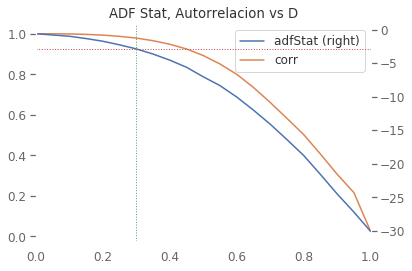

In [14]:
# Computo una lista de valores de d (el grado de diferenciación),
# y diferencio la serie de precios.
ds = np.linspace(0, 1, 21)
out = compute_multiple_ffd(mtum['Close'].to_frame(), 1e-3, ds)
print(out)

# Realizamos un plot para evaluar gráficamente el valor óptimo.
out[['adfStat','corr']].plot(secondary_y='adfStat')
mean_95conf = out['95% conf'].mean()
optim_d = get_d_optim(out, conf=0.05)
plt.axhline(mean_95conf,linewidth=1,color='r',linestyle='dotted')
plt.axvline(optim_d,linewidth=1,color='g',linestyle='dotted')
plt.grid()
plt.title('ADF Stat, Autorrelacion vs D')
print('Promedio de valores críticos para el estadístico al 5%: {}'.format(mean_95conf))
print('Valor óptimo de d: {}'.format(optim_d))

In [15]:
mtum['CloseFFD'] = fracDiff_FFD(mtum['Close'].to_frame(), d=optim_d, thres=1e-3)

# Generamos nuestro modelo para los labels

In [16]:
# Computamos los eventos de cruce de media moviles (a optimizar!)
fast_window_num_days = 3
slow_window_num_days = 7
tEvents = getEwmEvents(mtum['CloseFFD'], fast_window_num_days, slow_window_num_days)
print('tEvents')
print(tEvents)

tEvents
Date
2013-07-25    1
2013-07-30   -1
2013-08-01    1
2013-08-06   -1
2013-09-06    1
             ..
2020-07-24   -1
2020-08-03    1
2020-08-10   -1
2020-08-14    1
2020-09-04   -1
Length: 208, dtype: int64


In [17]:
# Definimos el tiempo de la barrera vertical. Esto es algo a optimizar
# y debe ajustarse en conjunto con los valores de retorno PT y SL.
num_days = 3

In [18]:
# Computamos las marcas temporales de la ventana. Para cada evento
# en tEvents (inicio de la ventana), obtenemos el final de la ventana.
# Nota: a diferencia de la notebook con labelling unicamente, tEvents 
#       aquí es una serie con el side de la apuesta por lo que debemos
#       pasar el indice a getVerticalBarrier() para reutilizar la funcion.
t1 = getVerticalBarrier(tEvents.index, mtum['CloseFFD'], numDays=num_days)
t1

Date
2013-07-25   2013-07-29
2013-07-30   2013-08-02
2013-08-01   2013-08-05
2013-08-06   2013-08-09
2013-09-06   2013-09-09
                ...    
2020-07-24   2020-07-27
2020-08-03   2020-08-06
2020-08-10   2020-08-13
2020-08-14   2020-08-17
2020-09-04   2020-09-08
Name: Date, Length: 208, dtype: datetime64[ns]

In [19]:
# Definimos las bandas de PT y SL.
ptSl = [0.015, 0.005]
# Computamos la volatilidad diaria, suavizada con una media
# movil pesada de 50 dias (arbitraria, también se podria aprender)
target = getDailyVol(close=mtum['CloseFFD'], span0=50)
# Seleccionamos el mínimo retorno considerado.
minRet = 0.01
# Numero de CPUs para el procesamiento en paralelo. 
cpus = 4

In [20]:
# Generamos los eventos de la triple frontera. En esta funcion obtenemos
# un dataframe cuyo indice es cuando ocurre el evento y tiene 2 columnasÑ
# - t1: momento en el que sucede el evento.
# - trgt: retorno obtenido en ese momento.
triple_barrier_events = getEvents(mtum['CloseFFD'],tEvents.index,ptSl,target,minRet,cpus,t1=t1,side=tEvents)
triple_barrier_events

2021-11-26 18:17:46.514389 100.0% applyPtSlOnT1 done after 0.0 minutes. Remaining 0.0 minutes.


,t1,trgt,side
Date,,,
2013-07-25,2013-07-26,0.034634,1
2013-07-30,2013-07-31,0.028489,-1
2013-08-01,2013-08-02,0.027982,1
2013-08-06,2013-08-07,0.032127,-1
2013-09-06,2013-09-09,0.039115,1
...,...,...,...
2020-07-24,2020-07-27,0.112750,-1
2020-08-03,2020-08-04,0.101879,1
2020-08-10,2020-08-11,0.093271,-1


# Luego los metalabels

In [21]:
# Obtenemos los labels! Los labels nos dan la siguiente informacion:
# - Indice: momento en el que ocurre el evento segun nuestra estrategia.
# - Columna ret: el retorno que vamos a obtener.
# - Columna bin: lo que sucede con la señal de la apuesta:
#   - 1: se toma la apuesta.
#   - 0: no se toma la apuesta.
labels = getBins(triple_barrier_events, mtum['CloseFFD'])
labels

,ret,bin
Date,,
2013-07-25,-0.000410,0.0
2013-07-30,0.004014,1.0
2013-08-01,0.008557,1.0
2013-08-06,0.013808,1.0
2013-09-06,0.030715,1.0
...,...,...
2020-07-24,-0.092516,0.0
2020-08-03,-0.003073,0.0
2020-08-10,0.080679,1.0


In [22]:
# Una pequeña tabla de contención que nos indica como se distribuyen
# los labels.
labels['bin'].value_counts()

0.0    133
1.0     75
Name: bin, dtype: int64

# Computamos el uniqueness de las muestras

In [23]:
# Obtengo los coeficientes de concurrencia para cada evento.
numCoEvents = mpPandasObj(mpNumCoEvents,('molecule',triple_barrier_events.index),cpus,
                          closeIdx=mtum.index,t1=triple_barrier_events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(mtum['CloseFFD'].index).fillna(0)

# Genero un data frame que contenga en una columna los pesos por concurrencia
# y en otra los pesos por concurrencia + retornos.
out=pd.DataFrame()
out['tW'] = mpPandasObj(mpSampleTW,('molecule',triple_barrier_events.index),cpus,
                        t1=triple_barrier_events['t1'],numCoEvents=numCoEvents)
out['w'] = mpPandasObj(mpSampleW,('molecule',triple_barrier_events.index),cpus,
                       t1=triple_barrier_events['t1'],numCoEvents=numCoEvents,close=mtum['CloseFFD'])
out['w'] *= out.shape[0]/out['w'].sum()
out

2021-11-26 18:17:46.900167 100.0% mpNumCoEvents done after 0.0 minutes. Remaining 0.0 minutes.
2021-11-26 18:17:47.068406 100.0% mpSampleTW done after 0.0 minutes. Remaining 0.0 minutes.
2021-11-26 18:17:47.236190 100.0% mpSampleW done after 0.0 minutes. Remaining 0.0 minutes.


,tW,w
2013-07-25,1.0,0.819113
2013-07-30,1.0,0.370925
2013-08-01,1.0,1.086121
2013-08-06,1.0,0.761460
2013-09-06,1.0,0.816392
...,...,...
2020-07-24,1.0,1.383857
2020-08-03,1.0,0.958543
2020-08-10,1.0,2.757428
2020-08-14,1.0,1.277200


In [24]:
averageUniqueness = out.mean()[0]
print('averageUniqueness:')
averageUniqueness

averageUniqueness:


0.9375

In [25]:
# Genero un data frame entre las concurrencias y los retornos diarios.
coEvents_std = (pd.DataFrame().assign(numCoEvents = numCoEvents, std = target))
coEvents_std

,numCoEvents,std
Date,,
2013-04-18,0.0,NaN
2013-04-19,0.0,NaN
2013-04-22,0.0,NaN
2013-04-23,0.0,NaN
2013-04-24,0.0,NaN
...,...,...
2020-09-09,0.0,0.100575
2020-09-10,0.0,0.102742
2020-09-11,0.0,0.102055


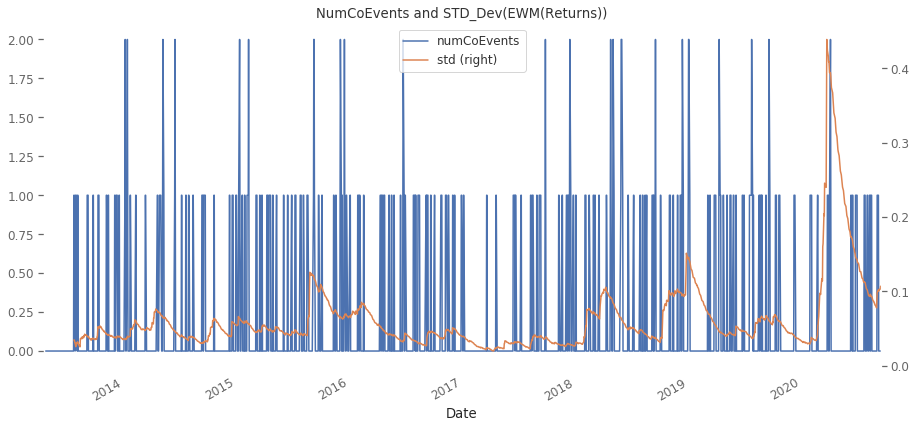

In [26]:
# Evaluamos los retornos y las concurrencias en la serie temporal.
fig, ax = plt.subplots(figsize=(15,7))
coEvents_std['numCoEvents'].plot(legend=True, ax=ax)
coEvents_std['std'].plot(secondary_y=True, legend=True, ax=ax)
plt.title('NumCoEvents and STD_Dev(EWM(Returns))')
plt.grid()
plt.show()

# Preparamos los parametros para los modelos

In [27]:
# Preparamos la informacion para introducirla en un modelo de ML.
Xy = (pd.merge_asof(triple_barrier_events, labels[['bin']],
                    left_index=True, right_index=True, 
                    direction='forward').dropna())
Xy = (pd.merge_asof(Xy, out.loc[Xy.index].w,
                    left_index=True, right_index=True, 
                    direction='forward').dropna())

# Preparamos la informacion para introducirla en un modelo de ML.
X = Xy.copy()[['trgt', 'side', 'w']].values
y = Xy.copy().bin.values # labels.bin.values
# Realizamos un train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)

## Random Forest base

In [28]:
# Hiperpametros
n_estimator = 1000     # Numero de arboles.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
max_depth = 2         # Numero de niveles que va a tener cada arbol. Al elegir un split binario
                      # permitimos que el entrenamiento sea mas lento.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# Para mas argumentos, revisar https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                            criterion=criterion, n_jobs=n_jobs, random_state=123)
rf.fit(X_train[:,0:2], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=4, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

Classification report
              precision    recall  f1-score   support

         0.0       0.65      0.86      0.74       109
         1.0       0.32      0.12      0.17        58

    accuracy                           0.60       167
   macro avg       0.48      0.49      0.46       167
weighted avg       0.53      0.60      0.54       167

Accuracy
0.6047904191616766


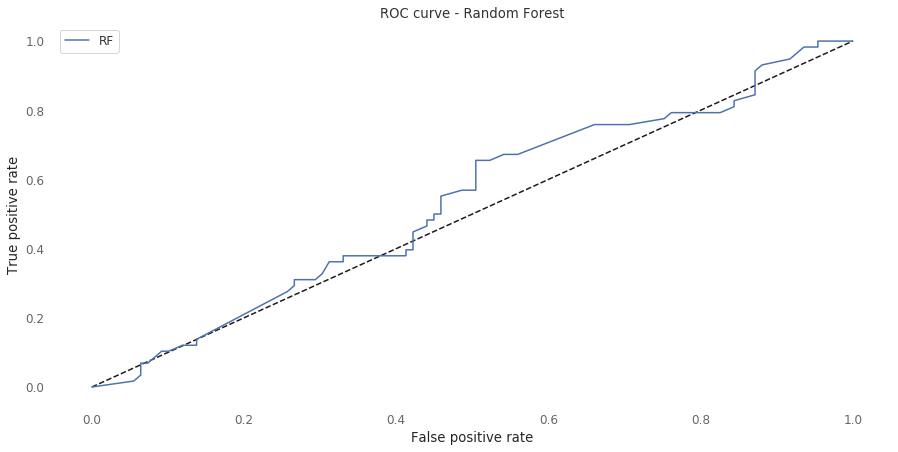

In [29]:
# Predecimos con el test set y contrastamos.
y_pred_rf_prob = rf.predict_proba(X_test[:,0:2])[:, 1]
y_pred_rf = rf.predict(X_test[:,0:2])

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
print("Classification report")
print(classification_report(y_test, y_pred_rf))

print("Accuracy")
print(accuracy_score(y_test, y_pred_rf))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Random Forest')
plt.legend(loc='best')
plt.grid()
plt.show()

## Random Forest con uniqueness

In [ ]:
# Hiperpametros
n_estimator = 1000     # Numero de arboles.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
max_depth = 2         # Numero de niveles que va a tener cada arbol. Al elegir un split binario
                      # permitimos que el entrenamiento sea mas lento.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# Para mas argumentos, revisar https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf2 = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                             criterion=criterion, n_jobs=n_jobs, random_state=123)
rf2.fit(X_train[:,0:2], y_train, sample_weight=X_train[:,2])

In [ ]:
# Predecimos con el test set y contrastamos.
y_pred_rf2_prob = rf2.predict_proba(X_test[:,0:2])[:, 1]
y_pred_rf2 = rf2.predict(X_test[:,0:2])

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_rf2, tpr_rf2, _ = roc_curve(y_test, y_pred_rf2_prob)
print("Classification report")
print(classification_report(y_test, y_pred_rf2))

print("Accuracy")
print(accuracy_score(y_test, y_pred_rf2))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf2, tpr_rf2, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Random Forest w/uniqueness')
plt.legend(loc='best')
plt.grid()
plt.show()

## Bagging base

In [ ]:
# Usamos bagging ahora
# Hiperpametros
n_estimator = 1000    # Numero de arboles.
max_samples = 0.5     # Porcion del data set a samplear para cada arbol.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
bc = BaggingClassifier(max_samples=max_samples, n_estimators=n_estimator,
                       n_jobs=n_jobs, random_state=123)
bc.fit(X_train[:,0:2], y_train)

In [ ]:
# Predecimos con el test set y contrastamos.
y_pred_bc_prob = bc.predict_proba(X_test[:,0:2])[:, 1]
y_pred_bc = bc.predict(X_test[:,0:2])

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_bc, tpr_bc, _ = roc_curve(y_test, y_pred_bc_prob)
print('Classification report')
print(classification_report(y_test, y_pred_bc))

print("Accuracy")
print(accuracy_score(y_test, y_pred_bc))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc, tpr_bc, label='BC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Bagging classifier')
plt.legend(loc='best')
plt.grid()
plt.show()

## Bagging con uniqueness I

In [ ]:
# Usamos bagging ahora
# Hiperpametros
n_estimator = 1000    # Numero de arboles.
max_samples = averageUniqueness     # Porcion del data set a samplear para cada arbol.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
bc2 = BaggingClassifier(max_samples=max_samples, n_estimators=n_estimator,
                       n_jobs=n_jobs, random_state=123)
bc2.fit(X_train[:,0:2], y_train)

In [ ]:
# Predecimos con el test set y contrastamos.
y_pred_bc2_prob = bc2.predict_proba(X_test[:,0:2])[:, 1]
y_pred_bc2 = bc2.predict(X_test[:,0:2])

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_bc2, tpr_bc2, _ = roc_curve(y_test, y_pred_bc2_prob)
print("Classification report")
print(classification_report(y_test, y_pred_bc2))

print("Accuracy")
print(accuracy_score(y_test, y_pred_bc2))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc2, tpr_bc2, label='BC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Bagging classifier with average uniqueness')
plt.legend(loc='best')
plt.grid()
plt.show()

## Bagging con uniqueness II

In [ ]:
# Usamos bagging ahora
# Hiperpametros
n_estimator = 1000    # Numero de arboles.
max_samples = 0.5     # Porcion del data set a samplear para cada arbol.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
bc3 = BaggingClassifier(max_samples=max_samples, n_estimators=n_estimator,
                       n_jobs=n_jobs, random_state=123)
bc3.fit(X_train[:,0:2], y_train, sample_weight=X_train[:,2])

In [ ]:
# Predecimos con el test set y contrastamos.
y_pred_bc3_prob = bc3.predict_proba(X_test[:,0:2])[:, 1]
y_pred_bc3 = bc3.predict(X_test[:,0:2])

# Realizamos un reporte de la clasificacion y realizamos una ROC.
fpr_bc3, tpr_bc3, _ = roc_curve(y_test, y_pred_bc3_prob)
print("Classification report")
print(classification_report(y_test, y_pred_bc3))

print("Accuracy")
print(accuracy_score(y_test, y_pred_bc3))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_bc3, tpr_bc3, label='BC')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Bagging classifier with average uniqueness')
plt.legend(loc='best')
plt.grid()
plt.show()

## Validacion cruzada base

In [ ]:
CV_SPLITS = 5

In [ ]:
# Hiperpametros
n_estimator = 1000     # Numero de arboles.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
max_depth = 2         # Numero de niveles que va a tener cada arbol. Al elegir un split binario
                      # permitimos que el entrenamiento sea mas lento.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.

skf = StratifiedKFold(n_splits=CV_SPLITS, shuffle=False, random_state=123)
rf_skf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                                criterion=criterion, n_jobs=n_jobs, random_state=123)
crossValPlot(skf,rf_skf,X,y)

## Validacion cruzada con embargo y purga

In [ ]:
# Busquemos un mejor modelo, entrenado con CV + Embargo.
PCT_EMBARGO = 0.01 # En porcentaje

# Hiperpametros
n_estimator = 1000    # Numero de arboles.
criterion = 'entropy' # Es un clasificador, necesitamos definir la metrica del modelo 
                      # que va a optimizar. Podria ser gini tambien.
max_depth = 2         # Numero de niveles que va a tener cada arbol. Al elegir un split binario
                      # permitimos que el entrenamiento sea mas lento.
n_jobs = 4            # Numero de threads que van a abrirse para entrenar mas rapido.
# Para mas argumentos, revisar https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

rf_pkf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                                criterion=criterion, n_jobs=n_jobs, random_state=123)

pkf = PurgedKFold(n_splits=CV_SPLITS, t1=t1, pctEmbargo=PCT_EMBARGO)

crossValPlot2(pkf,rf_pkf,Xy.copy()[['trgt', 'side', 'w']],Xy.copy().bin)

# Dimensionamiento de la apuesta (en \$ )

In [ ]:
# Tomamos las predicciones de un modelo, y modelamos el size del bet 
# a partir de la probabilidad.
# Predecimos con el test set y contrastamos.
NUM_CLASSES=2
JOBS=4

NUM_STEPS=5
STEP_SIZE=1/NUM_STEPS # No tocar!

# Las probabilidades y las predicciones tienen que ser series indexadas
# y apareadas con events (Xy).
x = Xy.copy()[['trgt', 'side']]
y_prob_df = pd.Series(data=rf.predict_proba(x.values)[:, 1], index=x.index)
y_pred_df = pd.Series(data=rf.predict(x.values), index=x.index)

bets = getSignal(triple_barrier_events, STEP_SIZE, y_prob_df, y_pred_df, NUM_CLASSES, JOBS)
print('Bet size with respect to the total budget:')
print(bets)

In [ ]:
BUDGET=1000000

fig, ax = plt.subplots(figsize=(15,7))
plt.scatter(x=bets.index, y=(bets * BUDGET))
plt.title('Bet size [$]')
plt.ylabel('Bet size [$]')
plt.grid()
plt.show()

## Backtesting

In [ ]:
# Baseline: buy and hold
base_returns = daily_return(mtum['Close'])
value_df = run_sample_and_hold_strategy(mtum['Close'], BUDGET)
strategy_report(base_returns, "B&H")

In [ ]:
plot_returns(base_returns, "B&H")

In [ ]:
plot_value(value_df)

In [ ]:
def run_self_funded_strategy(df, params):
    i=0
    last_portfolio_value = 1
    tx_costs = 0.
    
    for index,row in df.iterrows():
        if row['bets_usd'] > 0:
            bet = row['bets_usd']
            initial_price = row['Close']
            price_i = row['Close']
            # Will track the date index
            j = 1
            
            # Pays to enter the position
            df.loc[df.index[i], 'Value'] = df.loc[df.index[i], 'Value'] - row['bets_usd'] * params['buy_fee']
            tx_costs = tx_costs + np.abs(row['bets_usd'] * params['buy_fee'])

            # After t1_length without touching any of the barrier, the position
            # is dismantled. If it if happens before t1_length, then we do it earlier.
            while price_i < (initial_price * (1 + params['pt'])) and price_i > (initial_price * (1 - params['sl'])) and (j < params['t1_length'] + 1): #Cuando se cumple la condición, salimos de la posición
                price_i = df.loc[df.index[i+j], 'Close']
                df.loc[df.index[i+j], 'Value'] = df.loc[df.index[i], 'Value'] + row['bets_usd'] * (price_i / initial_price - 1.)
                last_portfolio_value = df.loc[df.index[i+j], 'Value']
                j = j + 1       
            
            # Fee to leave the position.
            df.loc[df.index[i+j-1]:, 'Value'] = last_portfolio_value - row['bets_usd'] * (price_i / initial_price) * params['sell_fee']
            tx_costs = tx_costs + np.abs(row['bets_usd'] * (price_i / initial_price) * params['sell_fee'])
        
        if row['bets_usd'] < 0:
            bet = row['bets_usd']
            initial_price = row['Close']
            price_i = row['Close']
            j = 1 # Will track the date index
            
            # Shorting BTC. Two fees needs to be paids, the sell + the loan fee.
            df.loc[df.index[i], 'Value'] = df.loc[df.index[i], 'Value'] - np.abs(row['bets_usd']) * params['sell_fee'] - np.abs(row['bets_usd']) * params['short_fee']
            tx_costs = tx_costs + np.abs(row['bets_usd']) * params['sell_fee'] + np.abs(row['bets_usd']) * params['short_fee']

            # Same as before, waiting for any barrier to be touched.
            while price_i < (initial_price * (1 + params['pt'])) and price_i > (initial_price * (1 - params['sl'])) and (j < params['t1_length'] + 1): #Cuando se cumple la condición, salimos de la posición
                price_i = df.loc[df.index[i+j], 'Close']
                df.loc[df.index[i+j], 'Value'] = df.loc[df.index[i], 'Value'] + row['bets_usd'] * (price_i / initial_price - 1.)
                last_portfolio_value = df.loc[df.index[i+j], 'Value']
                j = j + 1   
            # We pay the commission to leave the position.
            df.loc[df.index[i+j-1]:, 'Value'] = last_portfolio_value - np.abs(row['bets_usd']) * (price_i / initial_price) * params['buy_fee']
            tx_costs = tx_costs + np.abs(row['bets_usd']) * (price_i / initial_price) * params['buy_fee']

        # If there is no money, we stop.
        if last_portfolio_value <= 0.:
            break
        i = i + 1 # Moves forward with the next row.

    return df, tx_costs

def build_portfolio_self_funded_df(prices, bets, params):
    # Refactor the bets so they can be worked out.
    bets_df = bets.to_frame()
    bets_df.index.name = 'Timestamp'
    bets_df.rename(columns={0:'bets'}, inplace=True)

    # Generate a new df
    df = prices.to_frame().copy()
    df = pd.merge(df, bets_df, how='left', left_index=True, right_index=True)
    df['bets_usd'] = df['bets'] * params['budget']
    df['Value'] = params['budget']
    df.fillna(0, inplace=True)

    df, tx_costs = run_self_funded_strategy(df, params)
    df['rets'] = daily_return(df['Value'])

    return df, tx_costs

In [ ]:
params = {
    'budget': BUDGET,
    'buy_fee': 0.002,
    'sell_fee': 0.002,
    'short_fee':  np.power(1. + 0.01, num_days / 365.) - 1.,
    'pt': ptSl[0],
    'sl': ptSl[1],
    't1_length': num_days,
}
df, tx_costs = build_portfolio_self_funded_df(mtum['Close'], bets, params)

In [ ]:
# strategy_report(df['rets'].fillna(0.), 'SUT', underlying_asset_returns=base_returns)
strategy_report(df['rets'], 'SUT', underlying_asset_returns=base_returns)

In [ ]:
plot_returns(df['rets'], "SUT")

In [ ]:
plot_value(df['Value'])

In [ ]:
sr_stars = np.asarray([i / 100. for i in range(0, 101)])
psrs = [probabilistic_sharpe_ratio(returns=base_returns, sr_benchmark=sr_star) for sr_star in sr_stars]


plt.plot(sr_stars, psrs, color='blue', label='Odds ratio PSR buy and hold')
plt.legend()
plt.xlabel('Target Sharpe Ratio')
plt.ylabel('Probabilistic Sharpe Ratio')
plt.title('Baseline - Probabilistic Sharpe Ratio vs SR*')
plt.grid()
plt.show()

In [ ]:
sr_stars = np.asarray([i / 100. for i in range(0, 101)])
psrs = [probabilistic_sharpe_ratio(returns=df['rets'], sr_benchmark=sr_star) for sr_star in sr_stars]


plt.plot(sr_stars, psrs, color='blue', label='Odds ratio PSR buy and hold')
plt.legend()
plt.xlabel('Target Sharpe Ratio')
plt.ylabel('Probabilistic Sharpe Ratio')
plt.title('SUT - Probabilistic Sharpe Ratio vs SR*')
plt.grid()
plt.show()